# Imports

In [1]:
from pathlib import Path
import numpy as np
import torch
import math
from tqdm import tqdm
from torchvision.datasets import CocoDetection
import matplotlib.pyplot as plt
import torchvision

In [2]:
from abbyy_course_cvdl_t3.coco_text import COCO_Text
from abbyy_course_cvdl_t3 import coco_evaluation
from abbyy_course_cvdl_t3.utils import evaluate_ap_from_cocotext_json
from abbyy_course_cvdl_t3.utils import dump_detections_to_cocotext_json

In [3]:
cd ../task2

/home/alexander/computerScience/phystech/9sem/abbyy/course_cvdl/task2


In [4]:
import abbyy_course_cvdl_t2
from abbyy_course_cvdl_t2.convert import PointsToObjects, ObjectsToPoints
from abbyy_course_cvdl_t2.impl.train import train
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform
from abbyy_course_cvdl_t2.network import CenterNet
from abbyy_course_cvdl_t2.loss import CenterNetLoss

In [5]:
cd ../task3

/home/alexander/computerScience/phystech/9sem/abbyy/course_cvdl/task3


In [6]:
device = torch.device('cuda:0')

# Data

In [7]:
base = Path("/home/alexander/Downloads/coco2014/")
anno_path = base / 'cocotext.v2.json'
images_path = base / 'images/train2014'

assert anno_path.exists(), "Set your own path to annotation"
assert images_path.exists(), "Set your own path to images"


In [8]:
ct = COCO_Text(anno_path)

loading annotations into memory...
0:00:02.288427
creating index...
index created!


In [9]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]
        img[
                yc - hy//2 - thick : yc - hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val
        img[
                yc + hy//2 - thick : yc + hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val

        img[
                yc - hy//2 : yc + hy//2, 
                (xc - wx//2 - thick): (xc - wx//2 + thick), 
        ] = val
        img[
                yc - hy//2 : yc + hy//2, 
                xc + wx//2 - thick: xc + wx//2 + thick, 
        ] = val
    return img
        
        

In [10]:
n_classes = 2
input_shape = (256, 256)

In [11]:
ds_train = CocoTextDetection(
    Path("/home/alexander/Downloads/coco2014/images/train2014"),
    Path("/home/alexander/Downloads/coco2014/cocotext.v2.json"),
    transforms=CocoDetectionPrepareTransform(size=input_shape, #ids_map = {1: 0, 0: 0}
),
    area_fraction_threshold=1/32/32
)

In [12]:
ds_val = CocoTextDetection(
    images_path,
    Path(anno_path),
    transforms=CocoDetectionPrepareTransform(size=input_shape, #ids_map = {1: 0, 0: 0}
    ),
    area_fraction_threshold=1/32/32,
    split='val'
)

In [13]:
x, y = ds_train[6]

In [14]:
y[:10]

tensor([[133.8933,  60.5600,  12.5333,  13.4400,   1.0000,   1.0000],
        [131.5200, 156.7800,  11.5200,  19.8800,   1.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

In [15]:
trainloader = torch.utils.data.DataLoader(
    ds_train, batch_size=2, shuffle=True
)

In [16]:
valloader = torch.utils.data.DataLoader(
    ds_val, batch_size=1, shuffle=False
)

# Learning

In [17]:
net = CenterNet(head_kwargs={'c_classes': n_classes}, nms_kwargs={'kernel_size': 5})
crit = CenterNetLoss(obj_to_points=ObjectsToPoints(num_classes=n_classes))#, l_size_lambda=3)

In [18]:
net = train(ds_train, net=net, criterion=crit, batch_size=64, epochs=2, device=torch.device(device), lr=1e-3)

epoch 0|0; total loss:21.250370025634766
last losses: [636.7062377929688, 0.2838729918003082, 0.5209305286407471]
epoch 0|30; total loss:37.86045455932617
last losses: [2.1381149291992188, 0.24064692854881287, 0.3006743788719177]
epoch 0|60; total loss:2.5934572219848633
last losses: [2.0192294120788574, 0.2484820932149887, 0.27569779753685]
epoch 0|90; total loss:2.217926025390625
last losses: [1.3980631828308105, 0.22196190059185028, 0.21464797854423523]
epoch 0|120; total loss:2.050830841064453
last losses: [1.6335278749465942, 0.2832605540752411, 0.2680417597293854]
epoch 0|150; total loss:1.9618288278579712
last losses: [1.3981540203094482, 0.244850754737854, 0.1766047328710556]
epoch 0|180; total loss:1.9098724126815796
last losses: [1.3177756071090698, 0.25588715076446533, 0.2453632801771164]
epoch 0|210; total loss:1.7876875400543213
last losses: [1.3045116662979126, 0.24387890100479126, 0.28567376732826233]
epoch 0|240; total loss:1.7786327600479126
last losses: [1.23534536361

In [19]:
torch.save(net, 'centernet.pth')

# Quality

## Postprocessing and visualization

In [20]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [21]:
#net = torch.load('centernet.pth')

In [22]:
net.to(device)
net.eval()

CenterNet(
  (backbone): ResnetBackbone(
    (downscale): HeadlessPretrainedResnet18Encoder(
      (md): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3)

In [23]:
x, y = ds_train[6]

with torch.no_grad():
    yp_heat = net(x[None].to('cuda:0')).cpu()    
    yp = net(x[None].to('cuda:0'), return_objects=True).cpu()

class 0 heatmap


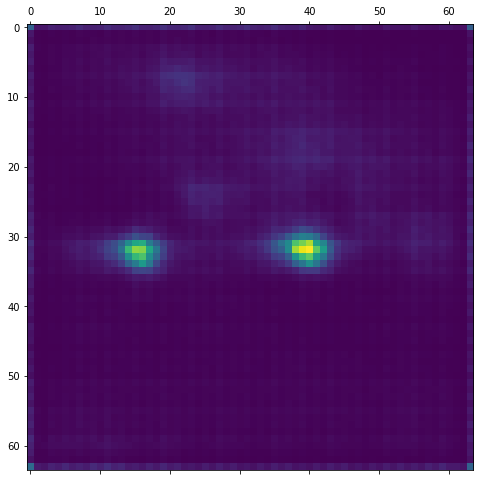

class 1 heatmap


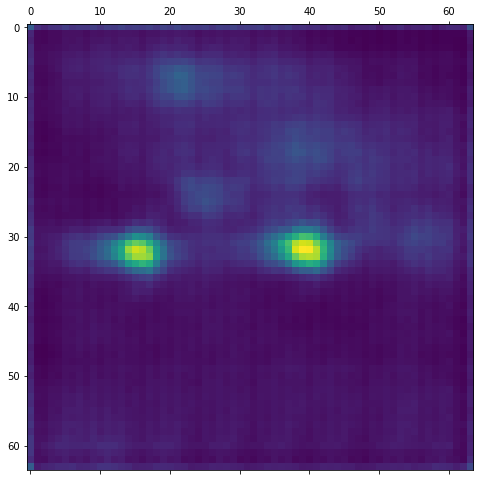

w_heatmap


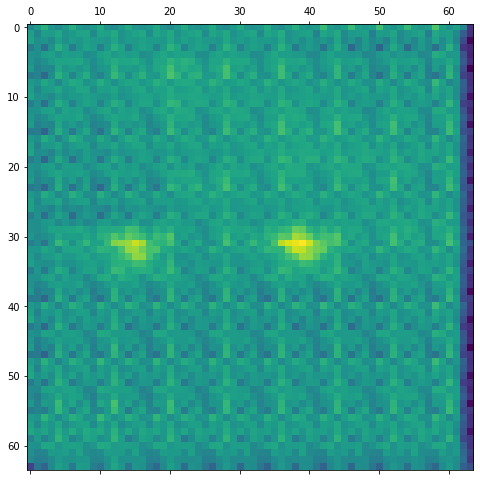

h heatmap


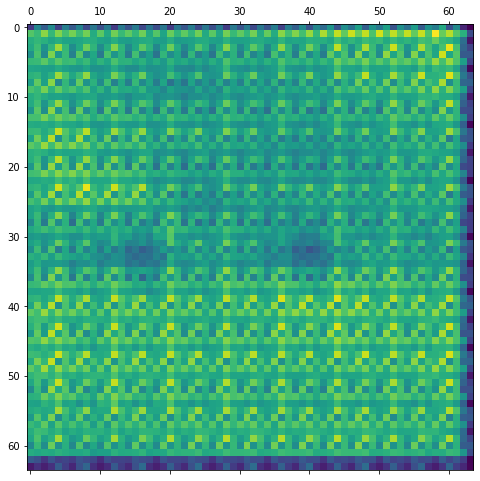

In [24]:
print('class 0 heatmap')
plt.matshow(yp_heat[0][0])
plt.show()

print('class 1 heatmap')
plt.matshow(yp_heat[0][1])
plt.show()

print('w_heatmap')
plt.matshow(yp_heat[0][-1])
plt.show()

print('h heatmap')
plt.matshow(yp_heat[0][-2])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


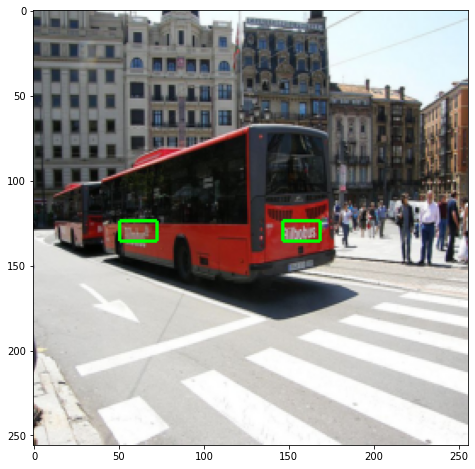

In [25]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]

        hyd2 = torch.div(hy, 2, rounding_mode='trunc')
        wxd2 = torch.div(wx, 2, rounding_mode='trunc')

        img[
                yc - hyd2 - thick : yc - hyd2 + thick, 
                xc - wxd2 : xc + wxd2, 
        ] = val
        img[
                yc + hyd2 - thick : yc + hyd2 + thick, 
                xc - wxd2 : xc + wxd2, 
        ] = val

        img[
                yc - hyd2 : yc + hyd2, 
                (xc - wxd2 - thick): (xc - wxd2 + thick), 
        ] = val
        img[
                yc - hyd2 : yc + hyd2, 
                xc + wxd2 - thick: xc + wxd2 + thick, 
        ] = val
    return img


rnd = lambda x: torch.round(x).long()

plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(yp[0, :3, 0]), rnd(yp[0, :3, 1]), rnd(yp[0, :3, 2]), rnd(yp[0, :3, 3]) 
))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


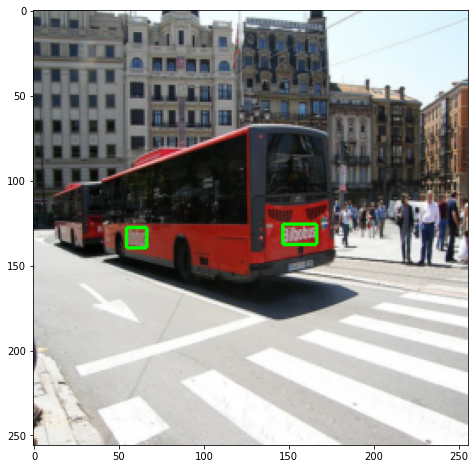

In [26]:
plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(y[:, 0]), rnd(y[:, 1]), rnd(y[:, 2]), rnd(y[:, 3]) 
))

In [27]:
yp

tensor([[[129.9755, 157.9911,  11.5832,  22.7811,   1.0000,   0.2176],
         [129.9693,  61.9965,  11.8678,  21.7333,   1.0000,   0.2014],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
      

In [28]:
y

tensor([[133.8933,  60.5600,  12.5333,  13.4400,   1.0000,   1.0000],
        [131.5200, 156.7800,  11.5200,  19.8800,   1.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,  

## Saving to json

In [ ]:
#net = torch.load('centernet.pth')

def postprocess(data, target_shape, input_shape, min_conf=0.1):
    unf = {}
    res = data[data[:, -1] > min_conf]
    boxes = res[:, :4].copy()
    b = boxes.copy()
    boxes[:, 0] = (boxes[:, 0] - b[:, 2] / 2) * (target_shape[0] / input_shape[0])
    boxes[:, 1] = (boxes[:, 1] - b[:, 3] / 2) * (target_shape[1] / input_shape[1])
    boxes[:, 2] = boxes[:, 2] * (target_shape[0] / input_shape[0])
    boxes[:, 3] = boxes[:, 3] * (target_shape[1] / input_shape[1])
    unf['boxes'] = boxes
    unf['scores'] = res[:, -2]
    return unf


def extract_results(min_conf=0.1):
    prepared_preds = []
    img_ids = []

    net.eval()

    for num, img_id in enumerate(tqdm(ds_val.ids)):
        img_id = int(img_id)
        img_meta = ct.loadImgs(ids=[img_id])[0]

        with torch.no_grad():
            x = ds_val[num][0]
            
            pred = net(
                x[None, ...].to(device),
                return_objects=True
            )[0].detach().cpu().numpy()
            prepared_preds.append(
                postprocess(pred, target_shape=(img_meta['height'], img_meta['width']), input_shape=input_shape, min_conf=min_conf)
            )
            img_ids.append(img_id)

    scores = np.concatenate([u['scores'] for u in prepared_preds], axis=0)
    boxes = np.concatenate([u['boxes'] for u in prepared_preds], axis=0)

    image_ids = []
    for num, i in enumerate(img_ids):
        image_ids += [i] * len(prepared_preds[num]['boxes'])
    image_ids = np.array(image_ids)

    #print(len(image_ids.tolist()),
    #    len(boxes[:, 0].tolist()),
    #    len(boxes[:, 1].tolist()),
    #    len(boxes[:, 2].tolist()),
    #    len(boxes[:, 3].tolist()),
    #    len(scores.tolist()))

    dump_detections_to_cocotext_json(
        image_ids = image_ids.tolist(),
        xlefts=boxes[:, 0].tolist(),
        ytops=boxes[:, 1].tolist(),
        widths=boxes[:, 2].tolist(),
        heights=boxes[:, 3].tolist(),
        scores=scores.tolist(),
        path=f'predictions_{min_conf}.json'
    )
    
    ap, prec, rec = evaluate_ap_from_cocotext_json(
    coco_text=ct,
    path=f'predictions_{min_conf}.json'
    )
    return (ap, prec, rec, min_conf, len(scores))

In [ ]:
min_conf=0.1
ap, prec, rec, conf, n_obj = extract_results(min_conf=min_conf)

print(f"Итоговый скор AP на val для min_conf={min_conf}: {ap}")

plt.plot(prec, rec)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('PR curve')
plt.grid()

# Best AP

In [ ]:
aps = []

for min_conf in np.linspace(0.1, 0.3, 5):
    ap, prec, rec, conf, n_obj = extract_results(min_conf=min_conf)

    aps.append((ap, min_conf))

    print(n_obj)
    print(f"Итоговый скор AP на val для min_conf={min_conf}: {ap}")
    plt.plot(prec, rec)
    plt.xlabel('precision')
    plt.ylabel('recall')
    plt.title('PR curve')
    plt.grid()
    plt.show()

In [ ]:
best_values = sorted(aps, key=lambda x: x[0])[-1]

In [ ]:
best_values